### Medium Dataset

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import os 
from zipfile import ZipFile, ZIP_DEFLATED

In [9]:
np.random.seed(42) # for reproducibility
num_repetitions = 5000
num_xs = 1000
x = np.linspace(0, 10, num_xs)
dataset_type = 'mediumdataset'

signals = np.zeros((num_repetitions, len(x)))
gauss_parameters = []

In [10]:
all_peaks = []

In [11]:
binary_peaks = np.zeros((num_repetitions, num_xs))

In [12]:

for i in range(num_repetitions):
    n_gauss = np.random.randint(10,25)
    signal = np.zeros(num_xs, )
    parameters = []
    peaks = []

    amp = np.random.uniform(0.5, 1.5)
    std_dev = np.random.uniform(0.05,0.2) # rule of thumb is 7 points per peak, maybe 5
    fwhm = 2 * np.sqrt(2 * np.log(2)) * std_dev
    # new mean cannot fall into any existing FWHM ranges

    # min_d = 0.08 # shouldn't be a constant; consider the width of the peak that it's under
    used_means = []

    for _ in range(n_gauss):
        attempts = 0
        while True:
            mean = np.random.uniform(1, 8)
            min_d = fwhm
            if all(abs(mean - m) >= min_d for m in used_means):
                used_means.append(mean)
                break
            attempts += 1
            if attempts > 200: # avoid inf loop
                break

        gauss = amp * np.exp(-((x - mean) ** 2) / (2 * std_dev ** 2))
        signal += gauss
        parameters.append((amp, mean, std_dev))

        peak_index = np.argmax(gauss)
        peaks.append(peak_index)
        binary_peaks[i][peak_index] = 1

    signals[i] = signal
    gauss_parameters.append(parameters)
    all_peaks.append(peaks)

    # make example figures of things in my workflow; going from 1 to 2 to more peaks

    # while loop will have another step


In [13]:
for i in range(num_repetitions):
    for idx in all_peaks[i]:
        binary_peaks[i][idx] = 1

In [14]:
all_peaks[0]

[np.int64(645),
 np.int64(517),
 np.int64(412),
 np.int64(170),
 np.int64(333),
 np.int64(200),
 np.int64(555),
 np.int64(139),
 np.int64(605),
 np.int64(756),
 np.int64(100),
 np.int64(794),
 np.int64(467),
 np.int64(380),
 np.int64(263),
 np.int64(701)]

In [15]:
np.argmax(signals[0], axis=0)

np.int64(170)

In [16]:
peak_indices = []

In [17]:
ds = xr.Dataset(
    {
        "Gaussians": (["pattern", "x"], signals),
        "BinaryArr": (["pattern", "x"], binary_peaks)
    },
    coords = {
        "pattern": np.arange(num_repetitions),
        "x": x
    }
)

In [18]:
gaussians = ds["Gaussians"].values
binary = ds["BinaryArr"].values

In [19]:
%matplotlib widget

In [20]:
plt.close()

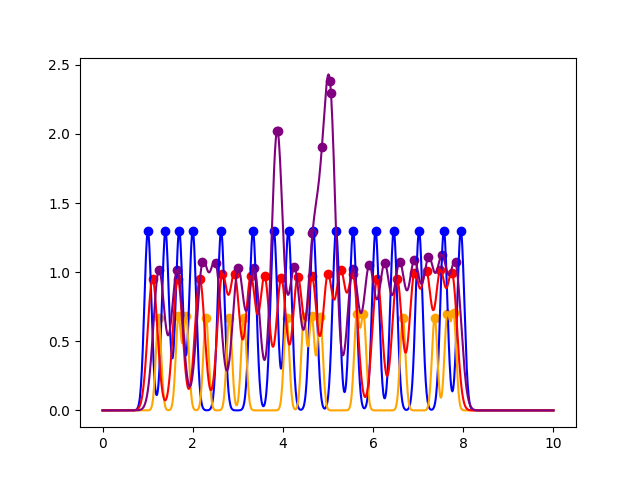

In [21]:
plt.figure()
colors = ['blue', 'orange', 'red', 'purple', 'green']
for i in range(4):
    plt.plot(x, signals[i], color=colors[i])
    plt.scatter(x[all_peaks[i]], signals[i][all_peaks[i]], color=colors[i])
plt.show()

In [22]:
path = '../saved_data/'
file = f'math_functions_{dataset_type}.nc'

ds.to_netcdf(os.path.join(path, file))
with ZipFile(os.path.join(path,file.replace('.nc','.zip')), 'w', ZIP_DEFLATED) as zObject:
    zObject.write(os.path.join(path,file), arcname=file)


In [28]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from scipy.stats import entropy

In [24]:
ds = xr.open_dataset(path + file)

In [25]:
gaussians = ds["Gaussians"].values
binary = ds["BinaryArr"].values
x = ds["x"].values
peak_idx = np.where(binary == 1)

In [26]:
random_state = 42

In [27]:
# Split data into train and test sets
gauss_train, gauss_test, binary_train, binary_test = train_test_split(gaussians, binary, test_size=0.2, random_state=random_state)

In [29]:
# Scale the features (the intensity values)
scaler = MinMaxScaler() # create the scaler object 

gauss_train = scaler.fit_transform(gauss_train)
gauss_test = scaler.transform(gauss_test)

In [30]:
from sklearn.utils.class_weight import compute_sample_weight
# sample_weights = compute_sample_weight(class_weight='balanced', y=binary_train)

In [ ]:
# Initialize the MLP classifier
mlp = MLPClassifier(hidden_layer_sizes=(600), max_iter=1000, random_state=random_state, verbose=True,
                   learning_rate_init=0.001,  # Default is 0.001; can increase or decrease
                    tol=1e-5,
                   early_stopping=False)


In [32]:
# Train the MLP classifier
mlp.fit(gauss_train, binary_train)

Iteration 1, loss = 287.39653641
Iteration 2, loss = 132.15745468
Iteration 3, loss = 114.98785749
Iteration 4, loss = 110.35854985
Iteration 5, loss = 106.88458870
Iteration 6, loss = 103.74994680
Iteration 7, loss = 100.60516303
Iteration 8, loss = 97.60788761
Iteration 9, loss = 94.55959166
Iteration 10, loss = 91.54197063
Iteration 11, loss = 88.88948879
Iteration 12, loss = 86.02320076
Iteration 13, loss = 83.87324507
Iteration 14, loss = 82.14251234
Iteration 15, loss = 80.77622134
Iteration 16, loss = 79.73519210
Iteration 17, loss = 78.90880109
Iteration 18, loss = 78.18074799
Iteration 19, loss = 77.80617550
Iteration 20, loss = 77.31654388
Iteration 21, loss = 76.87899992
Iteration 22, loss = 76.45242456
Iteration 23, loss = 76.07845583
Iteration 24, loss = 75.70093513
Iteration 25, loss = 75.35326678
Iteration 26, loss = 74.96325117
Iteration 27, loss = 74.62484552
Iteration 28, loss = 74.25153005
Iteration 29, loss = 73.88708836
Iteration 30, loss = 73.54534373
Iteration 31

,hidden_layer_sizes,600
,activation,'relu'
,solver,'adam'
,alpha,0.0001
,batch_size,'auto'
,learning_rate,'constant'
,learning_rate_init,0.001
,power_t,0.5
,max_iter,1000
,shuffle,True
,random_state,42


In [35]:
binary_pred = mlp.predict(gauss_test) # make predictions

In [36]:
probs = mlp.predict_proba(gauss_test)

In [37]:
two_classprobs = np.array([[i,1-i] for i in probs]) # 1-i will give probability for the 0 class
two_classprobs = two_classprobs.reshape((probs.shape[0],probs.shape[1],2)) # reshape to (num_samples, num_features, num_classes)

In [38]:
confidences = []
for i in range(two_classprobs.shape[0]):
    confidence = np.max(two_classprobs[i], axis=1) # returns max value for each of the features
    confidences.append(confidence)
confidences = np.array(confidences)

In [39]:
uncertainties = []
for i in range(two_classprobs.shape[0]):
    uncertainties.append(entropy(two_classprobs[i].T))
uncertainties = np.array(uncertainties)

(array([235, 285, 288, 289, 290, 295, 327, 372, 374, 407, 413, 456, 510,
       538, 539, 669, 706, 708, 710, 743, 744, 797]),)
(array([116, 131, 225, 226, 270, 426, 450, 473, 494, 513, 548, 554, 591,
       631, 649, 679, 737, 748, 778]),)
(array([167, 180, 185, 215, 291, 338, 354, 381, 406, 418, 447, 448, 454,
       467, 483, 502, 518, 520, 582, 591, 631, 634, 709, 712, 770, 778,
       785]),)
(array([131, 177, 178, 215, 218, 413, 415, 417, 424, 457, 601, 605, 694,
       734, 786]),)


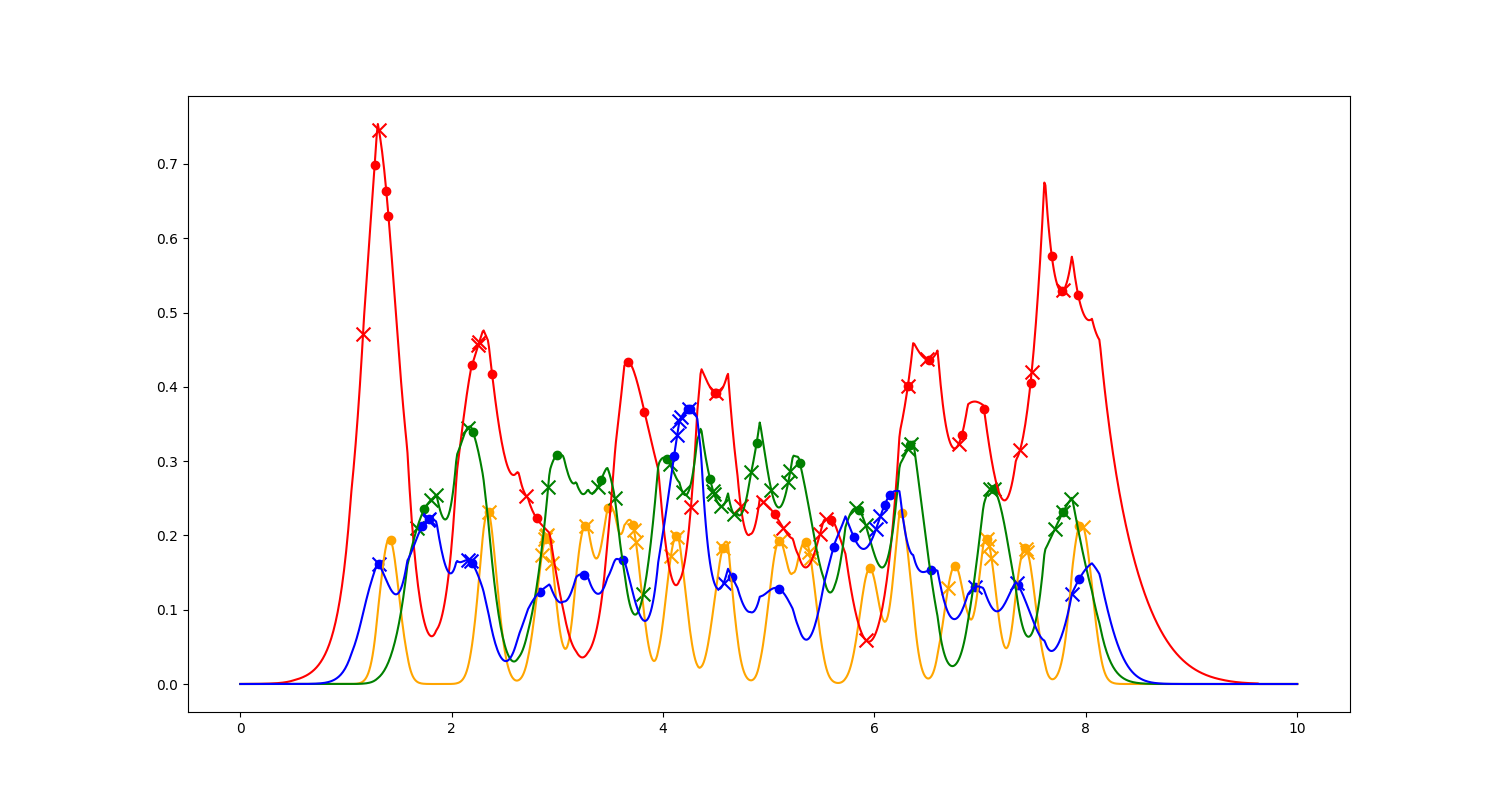

In [40]:
plt.close()
# plt.scatter(x, uncertainties)
# plt.scatter(x, confidences)

plt.figure(figsize=(15,8))
colors = [
    'orange', 'red', 'green', 'blue', 'purple', 'brown', 'pink', 'gray',
    'olive', 'cyan', 'magenta', 'teal', 'gold', 'navy', 'lime', 'maroon',
    'turquoise', 'darkorange', 'darkgreen', 'indigo'
]


for i in range(4):
    
    idx_true = np.where(binary_test[i] == 1)
    plt.scatter(x[idx_true], gauss_test[i][idx_true], marker='o', color=colors[i])
    plt.plot(x, gauss_test[i], color=colors[i])

    idx = np.where(binary_pred[i] == 1)
    print(idx)
    plt.scatter(x[idx], gauss_test[i][idx], marker='x', s = 100, color=colors[i])
  
    
   
plt.show()

In [41]:
%matplotlib widget

In [50]:
plt.close('all')

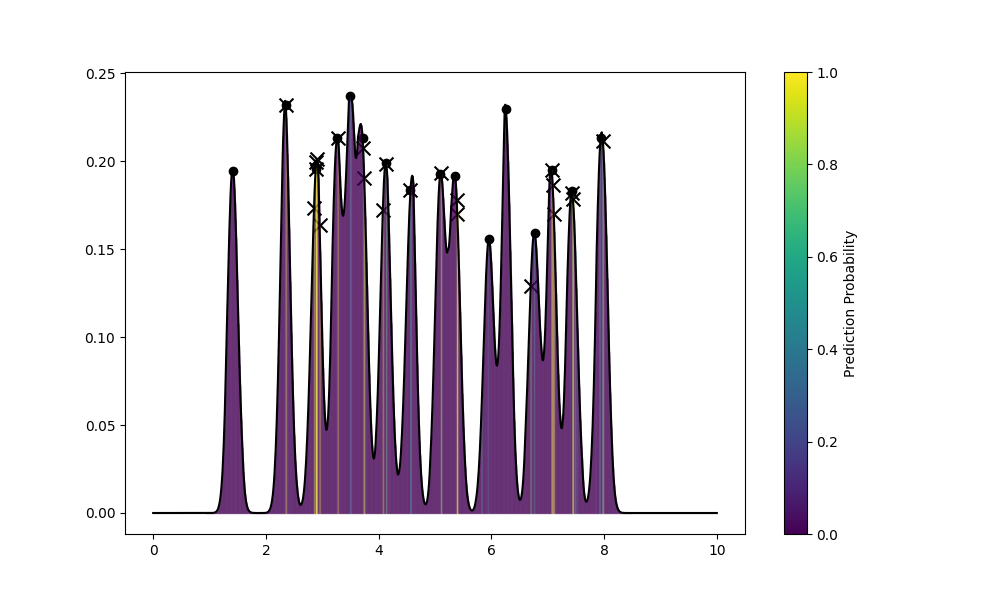

In [52]:
import matplotlib.colors as mcolors
import matplotlib.cm as cm

cmap = cm.viridis  # You can choose any colormap
norm = mcolors.Normalize(vmin=0, vmax=1)

plt.close()

plt.figure(figsize=(10,6))
# colors = [
#     'orange', 'red', 'green', 'blue', 'purple', 'brown', 'pink', 'gray',
#     'olive', 'cyan', 'magenta', 'teal', 'gold', 'navy', 'lime', 'maroon',
#     'turquoise', 'darkorange', 'darkgreen', 'indigo'
# ]

colors = ['black']

for i in range(1):
    # True peaks
    idx_true = np.where(binary_test[i] == 1)
    plt.scatter(x[idx_true], gauss_test[i][idx_true], marker='o', color=colors[i])

    # Full curve
    plt.plot(x, gauss_test[i], color=colors[i])

    # ML-predicted peaks
    idx = np.where(binary_pred[i] == 1)
    plt.scatter(x[idx], gauss_test[i][idx], marker='x', s=100, color=colors[i])
    
    # Shade under the curve with color based on prediction probabilities
    for j in range(len(x)-1):
        plt.fill_between(x[j:j+2], gauss_test[i][j:j+2], color=cmap(norm(probs[i][j])), alpha=0.3)

# Add colorbar
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, ax=plt.gca(), label='Prediction Probability')

plt.show()

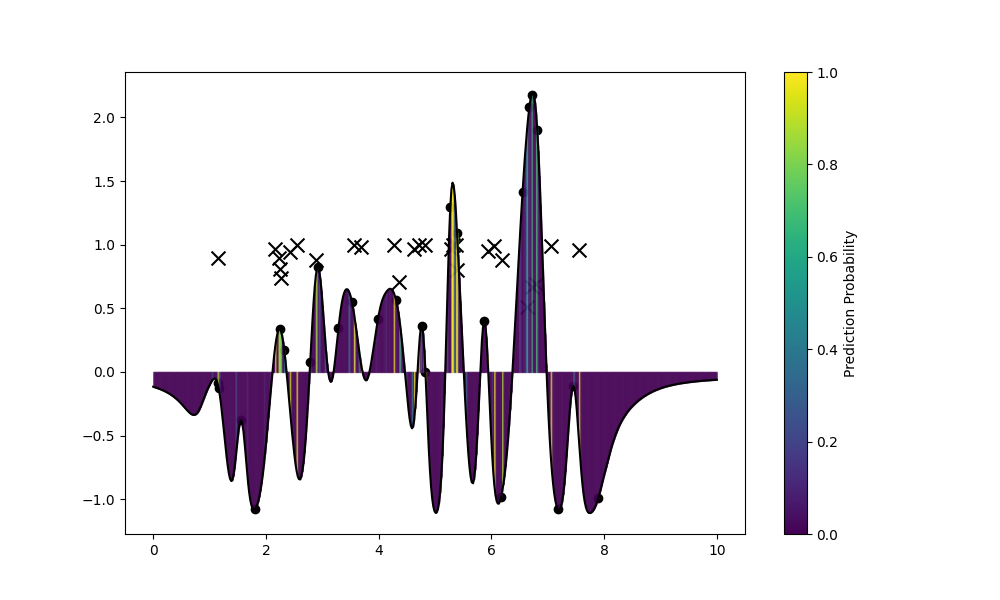

In [38]:
import matplotlib.colors as mcolors
import matplotlib.cm as cm

cmap = cm.viridis  # You can choose any colormap
norm = mcolors.Normalize(vmin=0, vmax=1)

plt.close()

plt.figure(figsize=(10,6))

colors = ['black', 'black']

for i in range(1,2):
    # True peaks
    idx_true = np.where(binary_test[i] == 1)
    plt.scatter(x[idx_true], gauss_test[i][idx_true], marker='o', color=colors[i])

    # Full curve
    plt.plot(x, gauss_test[i], color=colors[i])

    # ML-predicted peaks
    idx = np.where(binary_pred[i] == 1)
    plt.scatter(x[idx], probs[i][idx], marker='x', s=100, color=colors[i])
    
    # Shade under the curve with color based on prediction probabilities
    for j in range(len(x)-1):
        plt.fill_between(x[j:j+2], gauss_test[i][j:j+2], color=cmap(norm(probs[i][j])), alpha=0.6)

# Add colorbar
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, ax=plt.gca(), label='Prediction Probability')

plt.show()

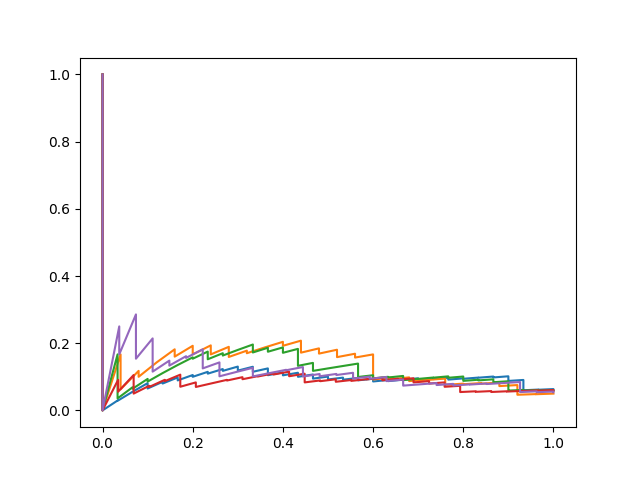

In [39]:
from sklearn.metrics import precision_recall_curve, average_precision_score
plt.close()
num_test_samples = binary_test.shape[1]
plt.figure()
for i in range(min(num_test_samples, 5)):

    precision, recall, thresholds = precision_recall_curve(binary_test[i, :], probs[i,:])
    avg_prec = average_precision_score(binary_test[i, :], probs[i,:])
    plt.plot(recall, precision)

plt.show()

In [26]:
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint

In [27]:
rf = RandomForestClassifier(n_estimators=200,
                        max_depth=None,
                        verbose=3,
                        class_weight="balanced",
                        n_jobs=-1,
                        random_state=42)

In [28]:
rf.fit(gauss_train, binary_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


building tree 1 of 200
building tree 2 of 200
building tree 5 of 200
building tree 6 of 200
building tree 4 of 200
building tree 7 of 200
building tree 8 of 200
building tree 10 of 200
building tree 11 of 200
building tree 9 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 3 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
b

[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:  1.0min


building tree 113 of 200
building tree 114 of 200
building tree 115 of 200
building tree 116 of 200
building tree 117 of 200
building tree 118 of 200
building tree 119 of 200
building tree 120 of 200
building tree 121 of 200
building tree 122 of 200
building tree 123 of 200
building tree 124 of 200
building tree 125 of 200
building tree 126 of 200
building tree 127 of 200
building tree 128 of 200
building tree 129 of 200
building tree 130 of 200
building tree 131 of 200
building tree 132 of 200
building tree 133 of 200
building tree 134 of 200
building tree 135 of 200
building tree 136 of 200
building tree 137 of 200
building tree 138 of 200
building tree 139 of 200
building tree 140 of 200
building tree 141 of 200
building tree 142 of 200
building tree 143 of 200
building tree 144 of 200
building tree 145 of 200
building tree 146 of 200
building tree 147 of 200
building tree 148 of 200
building tree 149 of 200
building tree 150 of 200
building tree 151 of 200
building tree 152 of 200


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  2.0min finished


,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [29]:
binary_pred = rf.predict(gauss_test) # make predictions

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  96 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:    0.9s finished


(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)


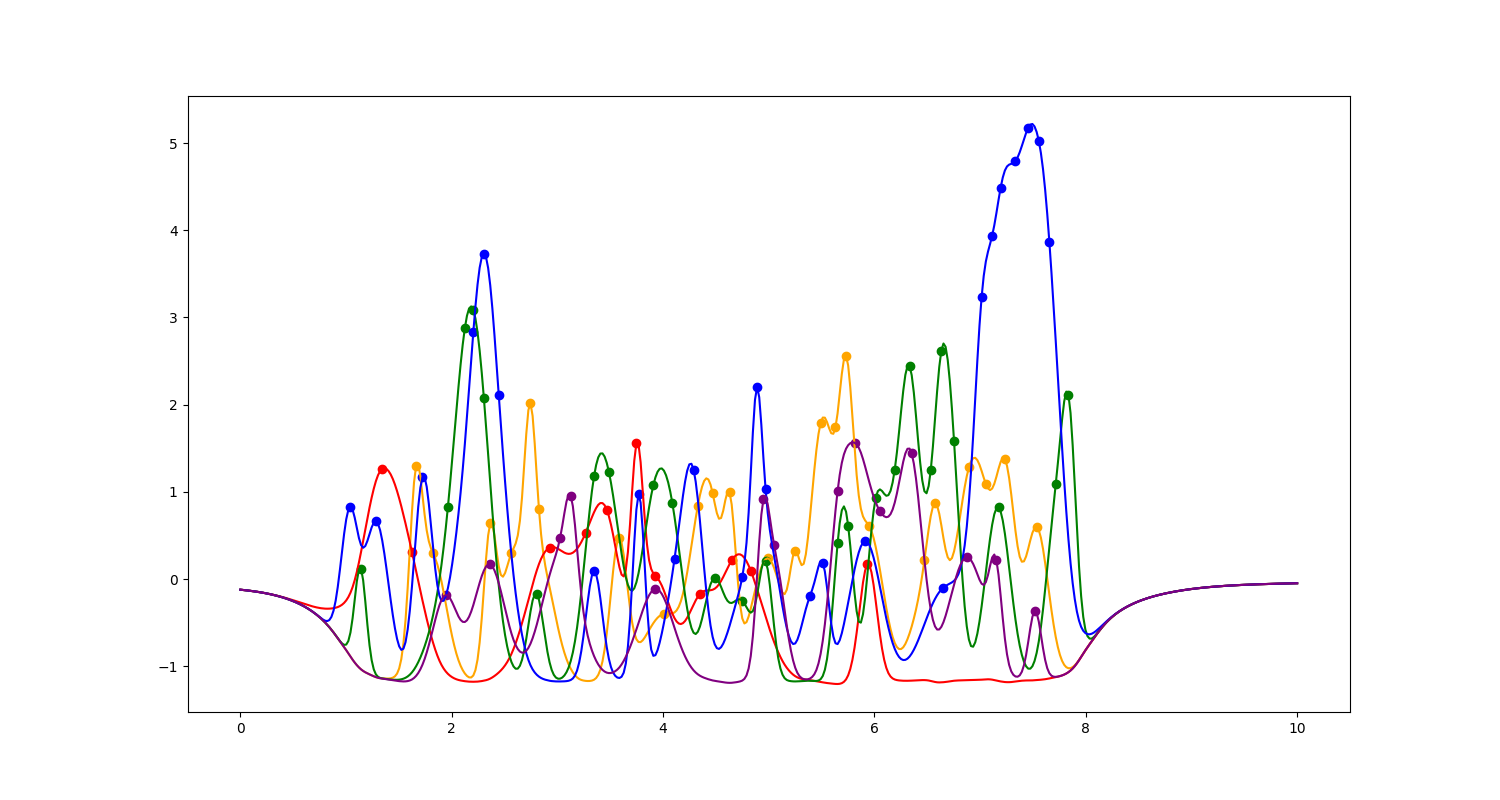

In [30]:
plt.close()
# plt.scatter(x, uncertainties)
# plt.scatter(x, confidences)

plt.figure(figsize=(15,8))
colors = [
    'orange', 'red', 'green', 'blue', 'purple', 'brown', 'pink', 'gray',
    'olive', 'cyan', 'magenta', 'teal', 'gold', 'navy', 'lime', 'maroon',
    'turquoise', 'darkorange', 'darkgreen', 'indigo'
]


for i in range(5):
    
    idx_true = np.where(binary_test[i] == 1)
    plt.scatter(x[idx_true], gauss_test[i][idx_true], marker='o', color=colors[i])
    plt.plot(x, gauss_test[i], color=colors[i])

    idx = np.where(binary_pred[i] == 1)
    print(idx)
    plt.scatter(x[idx], gauss_test[i][idx], marker='x', s = 100, color=colors[i])
  
    
   
plt.show()

In [ ]:
# Plotting a few patterns with the probability of label = 1 ("is a peak") as a shaded region.
# You can use a second y-axis on the right for this probability (0 - 1). These will show if
# 1) peaks are generally being found in the vicinity of a peak and 2) if the boundary for
# "is a peak" needs to be adjusted.

### Convolution

In [ ]:
n_gauss = 2
signal_1 = np.zeros(num_xs, )
signal_2 = np.zeros(num_xs, )

parameters = []
peaks = []

min_d = 0.08
used_means = []

for i in range(n_gauss):
    attempts = 0
    while True:
        mean = np.random.uniform(1, 8)
        if all(abs(mean - m) >= min_d for m in used_means):
            used_means.append(mean)
            break
        attempts += 1
        if attempts > 80: # avoid inf loop
            break

    amp = np.random.uniform(0.5, 1.5)
    std_dev = np.random.uniform(0.05,0.2)

    gauss = amp * np.exp(-((x - mean) ** 2) / (2 * std_dev ** 2))
    if i == 0: signal_1 += gauss
    if i == 1: signal_2 += gauss

signals = np.convolve(signal_1, signal_2, mode='same')

In [ ]:
plt.close()
plt.figure()
plt.plot(x, signal_1)
plt.plot(x, signal_2)
plt.plot(x, signals, label='Convolved signals')
plt.legend()

### Sum of Squares

In [ ]:

signals_sum_sq = np.sqrt(signal_1**2 + signal_2**2)

In [ ]:
plt.close()
plt.figure()
plt.plot(x, signal_1, color='black')
plt.plot(x, signal_2, color='red',alpha=0.5)
plt.plot(x, signals_sum_sq+0.5, linestyle='--', label='Sum of squares', color='green')
plt.legend()

### Adding Signals

In [ ]:
signals_add = np.zeros(num_xs, )
print(signals_add.shape)
signals_add += signal_1
print(signals_add.shape)
signals_add += signal_2
print(signals_add.shape)


In [ ]:
plt.close()
plt.figure()
plt.plot(x, signal_1)
plt.plot(x, signal_2)
plt.plot(x, signals_add+0.5, linestyle='--', label="adding signals")
plt.legend()

In [ ]:
if signals_sum_sq.all() == signals_add.all(): print('True')

In [ ]:
all_peaks[0]

In [ ]:
np.argmax(signals[0], axis=0)